<a href="https://colab.research.google.com/github/MINDS-edu/The-5th-POSTECH-Youth-Mathematical-Artificial-Intelligence-Academy/blob/master/PYMAIA5_day3_CNN_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 수업 전체 순서: MLP vs CNN 손글씨 인식 실습

3주차 실습 수업에서는 MLP(다층 퍼셉트론)과 CNN(합성곱 신경망)의 차이를 직접 코드로 실험해보며 이해합니다.  
마지막에는 내가 그린 손글씨 숫자를 두 모델에 입력해 비교합니다.

# Part 1. MNIST 손글씨 데이터 살펴보기

## 🎯 목표
- 우리가 사용할 손글씨 숫자 데이터셋(MNIST)가 어떤 모습인지 직접 눈으로 확인한다.
- 신경망을 돌리기 전에, 데이터를 먼저 이해하는 습관을 만든다.

## 🧾 MNIST란?
- 0부터 9까지의 손글씨 숫자 이미지로 이루어진 데이터셋.
- 각 이미지는 **28×28 픽셀**, 흑백 이미지.
- 학습용 60,000장, 테스트용 10,000장으로 구성된다.

2025-12-01 00:21:51.737336: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-01 00:21:51.778600: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-01 00:21:52.682841: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
x_train shape: (60000, 28, 28)
y_train shape: (60000,)


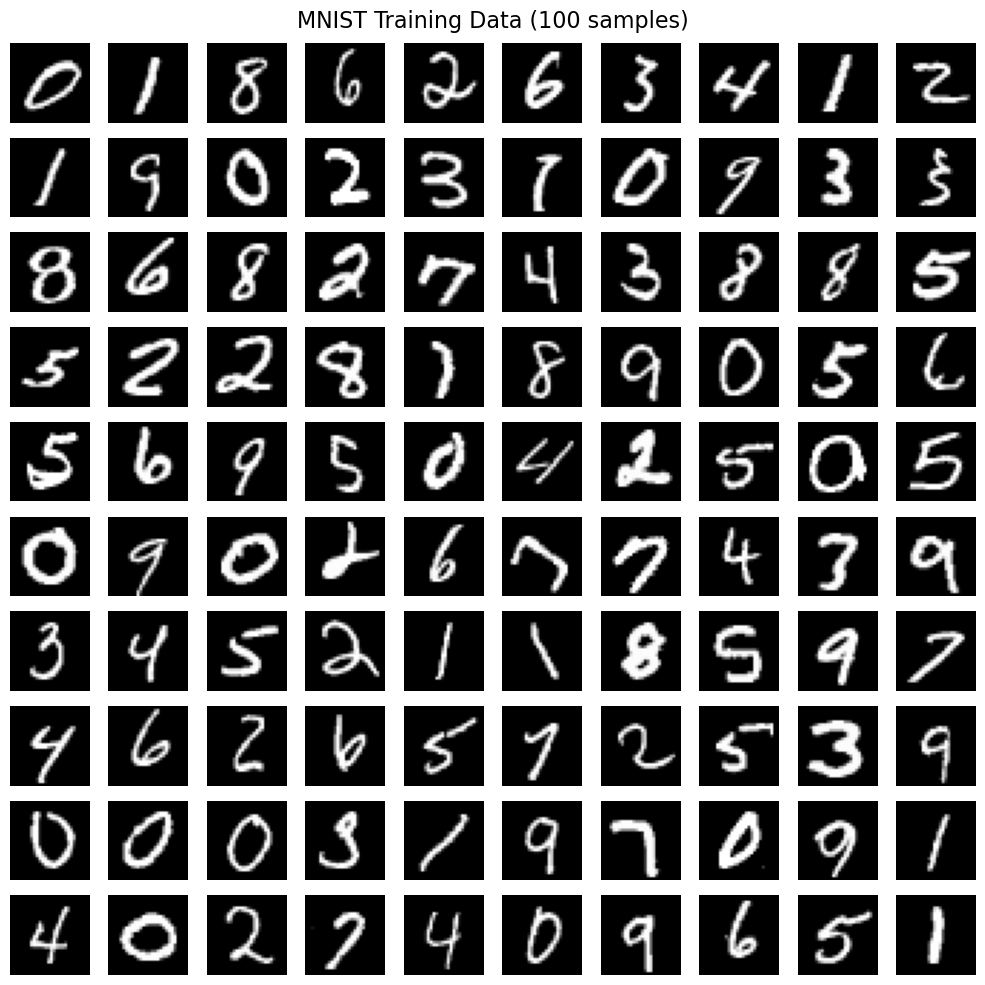

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# 1. 데이터 불러오기
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

# 2. 임의의 100개 데이터 인덱스 선택
indices = np.random.choice(len(x_train), size=100, replace=False)

# 3. 10x10 격자로 이미지 출력
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, index in enumerate(indices):
    row = i // 10
    col = i % 10
    axes[row, col].imshow(x_train[index], cmap='gray')
    axes[row, col].axis('off')
plt.suptitle("MNIST Training Data (100 samples)", fontsize=16)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Label: 5')

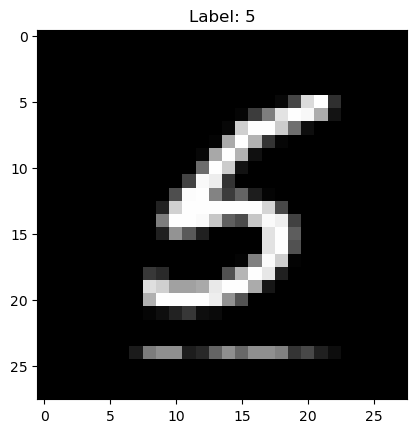

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
(x_train, y_train), (x_test, y_test) = mnist.load_data()
i = 775# @param {type:"raw"}
plt.imshow(x_train[i], cmap='gray')
plt.title(f"Label: {y_train[i]}")

# Part 2. MLP(다층 퍼셉트론)으로 손글씨 인식해보기

## 🎯 목표
- MLP(다층 퍼셉트론)가 무엇인지 이해한다.
- MNIST 숫자를 MLP에 넣어서 분류하고, 정확도를 확인한다.

## 🧠 MLP(Multi-Layer Perceptron)란?

MLP는 **입력층 → 여러 개의 은닉층 → 출력층**으로 구성된 가장 기본적인 형태의 인공신경망입니다. 모든 노드가 다음 층의 모든 노드와 연결되는 **완전연결(fully connected)** 구조를 사용합니다. 특히 이미지를 입력으로 사용할 때는 2차원 이미지를 그대로 쓰지 않고, 예를 들어 **28×28 이미지 → 길이 784의 벡터**로 **평탄화(flatten)** 해서 MLP에 넣습니다.

## 🔧 MLP의 동작 방식

### 1️⃣ 여러 개의 다른 선형함수를 만들고 각각 활성화 함수 적용
각 노드 $h_i$는 입력 $x$에 대해 서로 다른 선형함수

$$
z_i = a_i x + b_i
$$

를 만들고, 여기에 활성화 함수 $\sigma(z_i)$를 적용합니다.

<img src=https://raw.githubusercontent.com/MINDS-edu/The-5th-POSTECH-Youth-Mathematical-Artificial-Intelligence-Academy/refs/heads/master/warehouse/first_layer.gif height=300px;>

### 2️⃣ 활성화 함수를 통과한 값들을 다시 다른 선형함수에 입력
첫 번째 층의 출력을 벡터로 묶은 뒤, 다음 층에서 다시 선형변환 → 활성화 과정을 반복합니다.
<img src=https://raw.githubusercontent.com/MINDS-edu/The-5th-POSTECH-Youth-Mathematical-Artificial-Intelligence-Academy/refs/heads/master/warehouse/second_third_layer.gif height=300px;>

이 과정을 여러 번 반복하면 깊은 신경망(Deep Neural Network)이 됩니다.

## ⚠️ MLP의 한계점

MLP는 이미지 입력을 **펼쳐서(flatten)** 사용하기 때문에 중요한 문제점이 있습니다.

- **공간적 구조(spatial structure)가 완전히 사라짐**
  - 어떤 픽셀이 왼쪽/오른쪽, 위/아래에 있는지 관계를 알 수 없음
- 따라서 다음과 같은 특징을 스스로 이해하기 어렵다.
  - “획이 연결되어 있다”
  - “대각선 모양이다”
  - “가까운 픽셀끼리 의미가 있다”

→ 이런 이유로 **이미지 처리에는 CNN(Convolutional Neural Network)**이 등장했습니다.

/home/qudrb6989/miniconda3/envs/mlp_cnn/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1764516172.311444 1743994 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43622 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1764516172.312075 1743994 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 43622 MB memory:  -> device: 1, name: NVIDIA L40S, pci bus id: 0000:02:00.0, compute capability: 8.9
I0000 00:00:1764516172.312527 1743994 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 43622 MB memory:  -> device: 2, name: NVIDIA L40S, pci bus id: 0000:c

Epoch 1/5


2025-12-01 00:22:53.840379: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fb14000b300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-01 00:22:53.840402: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2025-12-01 00:22:53.840407: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (1): NVIDIA L40S, Compute Capability 8.9
2025-12-01 00:22:53.840410: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (2): NVIDIA L40S, Compute Capability 8.9
2025-12-01 00:22:53.840412: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (3): NVIDIA L40S, Compute Capability 8.9
2025-12-01 00:22:53.856163: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-01 00:22:53.944860: I external/local_xla/xla/st

137/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6891 - loss: 1.0777

I0000 00:00:1764516176.035586 1744768 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8239 - loss: 0.6201

2025-12-01 00:22:56.676929: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-01 00:22:56.676977: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-01 00:22:56.676993: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-01 00:22:56.677001: I external/l

469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9071 - loss: 0.3292 - val_accuracy: 0.9539 - val_loss: 0.1558
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9610 - loss: 0.1320 - val_accuracy: 0.9671 - val_loss: 0.1102
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9732 - loss: 0.0909 - val_accuracy: 0.9710 - val_loss: 0.0970
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9791 - loss: 0.0681 - val_accuracy: 0.9722 - val_loss: 0.0907
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9826 - loss: 0.0554 - val_accuracy: 0.9743 - val_loss: 0.0802


2025-12-01 00:23:02.377189: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-01 00:23:02.377242: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-01 00:23:02.619027: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_66', 8 bytes spill stores, 8 bytes spill loads

2025-12-01 00:23:02.773267: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Reg

MLP Test Accuracy: 0.9743000268936157


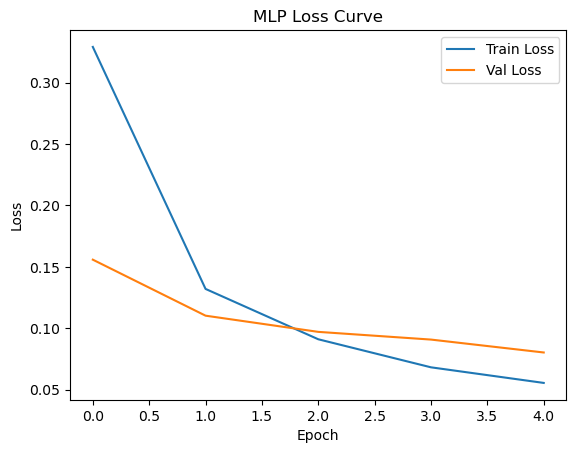

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

# 1. 데이터 정규화 (0~255 -> 0~1)
x_train_norm = x_train.astype('float32') / 255.0
x_test_norm  = x_test.astype('float32') / 255.0

# 2. (28,28) -> (784,)
x_train_mlp = x_train_norm.reshape(-1, 28*28)
x_test_mlp  = x_test_norm.reshape(-1, 28*28)

# 3. 레이블을 one-hot 벡터로 변환 (예: 3 -> [0,0,0,1,0,0,0,0,0,0])
y_train_cat = to_categorical(y_train, 10)
y_test_cat  = to_categorical(y_test, 10)

# 4. MLP 모델 정의
mlp = Sequential()
mlp.add(Dense(128, activation='relu', input_shape=(784,)))
mlp.add(Dense(64, activation='relu'))
mlp.add(Dense(10, activation='softmax'))

mlp.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 5. 학습
history_mlp = mlp.fit(
    x_train_mlp, y_train_cat,
    epochs=5,
    batch_size=128,
    validation_data=(x_test_mlp, y_test_cat),
    verbose=1
)

# 6. 성능 평가
mlp_loss, mlp_acc = mlp.evaluate(x_test_mlp, y_test_cat, verbose=0)
print("MLP Test Accuracy:", mlp_acc)

# 7. 학습 곡선 확인
plt.plot(history_mlp.history['loss'], label='Train Loss')
plt.plot(history_mlp.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLP Loss Curve')
plt.legend()
plt.show()

# Part 3. CNN 이론

##컨볼루션 레이어
![](https://i.sstatic.net/9bi5k.gif)

##ReLU
![](https://www.google.com/url?sa=i&url=https%3A%2F%2Fmedium.com%2F%40srivastavashivansh8922%2Funderstanding-the-difference-between-relu-and-sigmoid-activation-functions-in-deep-learning-33b280fc2071&psig=AOvVaw3dZ3on5QXTVsfC3d5HMP3b&ust=1734201978220000&source=images&cd=vfe&opi=89978449&ved=0CBQQjRxqFwoTCMjSwvizpYoDFQAAAAAdAAAAABAE)
![An image](https://www.google.com/images/rss.png)
![An image](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*aEVZlqkcakVySV6ETqgfEg.png)

# 5. CNN 실습

## cnn코드


패키지 선언, 데이터 전처리

In [7]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 데이터 정규화
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 이미지 차원 변경 (채널 추가)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# 레이블 원-핫 인코딩
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)




CNN 모델 선언

In [8]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


컴파일

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

훈련

Test Loss: 2.317436933517456
Test Accuracy: 0.07739999890327454
Epoch 1/4
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8590 - loss: 0.4882 - val_accuracy: 0.9829 - val_loss: 0.0520
Epoch 2/4
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9822 - loss: 0.0592 - val_accuracy: 0.9876 - val_loss: 0.0431
Epoch 3/4
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9882 - loss: 0.0405 - val_accuracy: 0.9881 - val_loss: 0.0352
Epoch 4/4
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9906 - loss: 0.0297 - val_accuracy: 0.9891 - val_loss: 0.0344


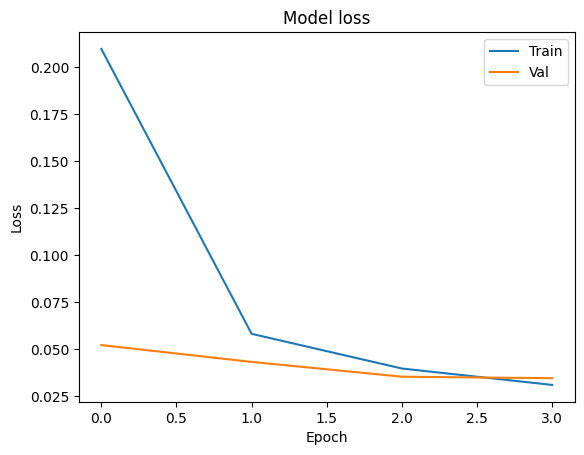

In [10]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)
history = model.fit(x_train, y_train, epochs=4, batch_size=128, validation_data=(x_test, y_test))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


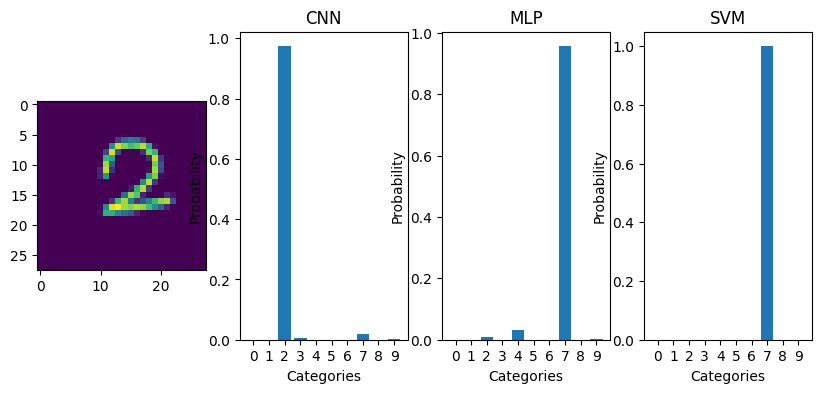

In [24]:
from PIL import Image

# PNG 파일 경로
image_path = 'canvas.png'  # 'your_image.png'를 실제 파일 경로로 변경

# PNG 파일 읽어오기
image = Image.open(image_path)

image = np.array(image.resize((28, 28))).astype('float32') / 255.0
image = image[:,:,3]
# 이미지 정보 출력 (선택 사항)
#print(image.format)  # 이미지 형식 출력
#print(image.size)  # 이미지 크기 출력
#print(image.mode)  # 이미지 모드 출력
fig,axs = plt.subplots(1,4,figsize=(10,4))
plt.sca(axs[0])
plt.imshow(image)
tns = ["CNN","MLP","SVM"]


for im in range(3):
  plt.sca(axs[im+1])
  if im ==0:
    tmpModel = model
    X = image.reshape(1, 28, 28, 1)
    pred = tmpModel.predict(X)[0]
  elif im ==1:
    tmpModel = mlp_3
    X = image.reshape(1,28*28)
    pred = tmpModel.predict(X)[0]
  elif im ==2:
    tmpModel = sgd_model
    tmp = tmpModel.predict(X)
    pred = np.zeros(10)
    pred[tmp] = 1




  pred[0]
  categories = ['0', '1', '2', '3', '4','5','6','7','8','9']
  values = [25, 35, 15, 20, 10]

  # bar 그래프 생성

  plt.bar(categories,pred)

  # 그래프 제목 및 레이블 설정
  plt.title(tns[im])
  plt.xlabel('Categories')
  plt.ylabel('Probability')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


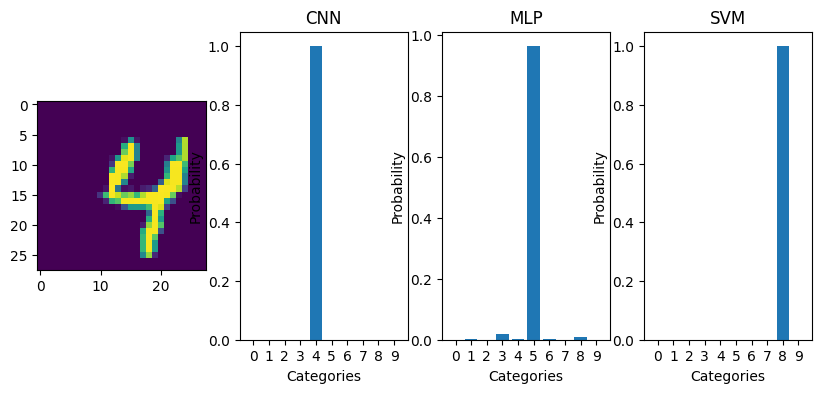

In [14]:
index_test = 1111 # @param {type:"raw"}
x_shift = 4 # @param {type:"raw"}
y_shift = 0 # @param {type:"raw"}
image = x_test[index_test,:,:,:]
image =  shifted_array = np.roll(image, shift=y_shift, axis=0)
image =  shifted_array = np.roll(image, shift=x_shift, axis=1)
# 이미지 정보 출력 (선택 사항)
#print(image.format)  # 이미지 형식 출력
#print(image.size)  # 이미지 크기 출력
#print(image.mode)  # 이미지 모드 출력
fig,axs = plt.subplots(1,4,figsize=(10,4))
plt.sca(axs[0])
plt.imshow(image)
tns = ["CNN","MLP","SVM"]


for im in range(3):
  plt.sca(axs[im+1])
  if im ==0:
    tmpModel = model
    X = image.reshape(1, 28, 28, 1)
    pred = tmpModel.predict(X)[0]
  elif im ==1:
    tmpModel = mlp_3
    X = image.reshape(1,28*28)
    pred = tmpModel.predict(X)[0]
  elif im ==2:
    tmpModel = sgd_model
    tmp = tmpModel.predict(X)
    pred = np.zeros(10)
    pred[tmp] = 1




  pred[0]
  categories = ['0', '1', '2', '3', '4','5','6','7','8','9']
  values = [25, 35, 15, 20, 10]

  # bar 그래프 생성

  plt.bar(categories,pred)

  # 그래프 제목 및 레이블 설정
  plt.title(tns[im])
  plt.xlabel('Categories')
  plt.ylabel('Probability')